In [1]:
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
import os 
import fnmatch
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\utils')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\tracking')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\time_alignement')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
from parameters import *
from tqdm import tqdm
from track_reconstruction import plot_hits
from physics import dist_line_rect
import pickle
from IPython import display
from find_muon_track import *
from find_muon_decay_kim import *
from time_correction import *



In [4]:
run ='run_000011'
current_directory = os.getcwd()
data_storage = current_directory+"\\extracted_data\\"
raw_data_directory = "C:\\Users\\Pascal\\Desktop\\TP4a\\data\\"
df_hits_total, df_hits, og_len, new_len = load_run(raw_data_directory+run+"\\")
good_candidates = np.loadtxt(data_storage+"events_indices_"+run+".txt")

%matplotlib inline
tracks = []
for i in range(len(good_candidates)) :
    event = df_hits.loc[good_candidates[i]]
    next_event = df_hits_total.loc[good_candidates[i]+1]

    hits = [Hit(event,i) for i in range(event['n_hits' ])]
    # print (hits)    
    Track = Track3D(hits)
    tracks.append(time_correction(Track))
    # print(track)


   

C:\Users\Pascal\Desktop\TP4a\data\run_000011\data_0000.root


selected 74.91% of all events


In [ ]:
# Computation of offsets and time resolution 



rows = 16
cols = 24
 
x_offset = [[0 for _ in range(cols)] for _ in range(rows/2)] # 8x24 matrix
y_offset = [[0 for _ in range(cols)] for _ in range(rows/2)] # 8x24 matrix


len_tracks = len(tracks)
print(len_tracks)


for k in [1]: #number of iteration of the whole process

    variance = [None]*len_tracks
    x_offset = [[0 for _ in range(cols)] for _ in range(rows)] # 16x24 matrix
    number_check = [[0]*16]*24

    # for the x layers first : **************************************************

    for i in range(8) :  #itaration on the 8 x-layers
        for j in range(24) : # iteration on the 24 bars on each layers
            mu =[]
            t_dist=[]
            for t in range(len(tracks)) : #iteration on all the tracks selected

                if tracks[t].x.hits[i].coord[0]==j : #does the track goes through the j bar ?
                    print(tracks[t].x.hits[i].coord[0])
                    number_check[j][i] += 1
                    t_track = [] #initialisation of the array with timestamp of other bars where the track goes through

                    t_bar =  tracks[t].x.hits[i].timestamp - x_offset[j][i] #initialisation of timestamp of bar i (xbar)
                    
                    # for z in (range(len(tracks[t].x.hits))) : #iteration on the 7 other x-layers 
                    for z in (range(8)) : #iteration on the 7 other x-layers 
                        if z != i : #we exclude the i layer
                            coordj = tracks[t].x.hits[z].coord[0]-1 #coordinate x where the track goes through on the z layer
                            t_track.append(tracks[t].x.hits[z].timestamp - x_offset[coordj][z]) 
                    for z in (range(8)) :  #iteration on the 8 other y-layers
                            coordj = tracks[t].y.hits[z].coord[0]-1 #coordinate y where the track goes through on the z layer
                            t_track.append(tracks[t].y.hits[z].timestamp - y_offset[coordj][z])
                        
                    t_track, variance[t] = norm.fit(t_track)
                    # print(t_track_tot)
                    # print(t_track-t_bar)
                    t_dist.append(t_track - t_bar)
                  

            mu, sigma[j][i] = norm.fit(t_dist)

            # x_offset[j][i]= mu

    # **************************************************************************************************************

    # for the y layers now :

    for i in range(8) :  #itaration on the 8 x-layers
            for j in range(24) : # iteration on the 24 bars on each layers
                mu =[]
                t_dist=[]
                for t in range(len(tracks)) : #iteration on all the tracks selected

                    if tracks[t].y.hits[i].coord[0]==j : #does the track goes through the j bar ?
                      
                        t_track = [] #initialisation of the array with timestamp of other bars where the track goes through

                        t_bar =  tracks[t].y.hits[i].timestamp - y_offset[j][i] #initialisation of timestamp of bar i (xbar)
                        
                        for z in (range(8)) : #iteration on the 7 other y-layers 
                            if z != i : #we exclude the i layer
                                coordj = tracks[t].y.hits[z].coord[0]-1 #coordinate y where the track goes through on the z layer
                                t_track.append(tracks[t].y.hits[z].timestamp - y_offset[coordj][z]) 
                        for z in range(8) :  #iteration on the 8 other x-layers
                                coordj = tracks[t].x.hits[z].coord[0]-1 #coordinate x where the track goes through on the z layer
                                t_track.append(tracks[t].x.hits[z].timestamp -x_offset[coordj][z]) 
                            
                        t_track_tot, variance[t] = norm.fit(t_track)
                        t_dist.append(t_track_tot - t_bar)

                mu, sigma[j][i+8] = norm.fit(t_dist)

                # y_offset[j][i]= mu

            # *************************************************************************************************************

    # computation of variance of the algorithm for each process iteration k

    variance_tot = mean(variance)
    print(str(k)+"_variance = " +str(variance_tot))
    sigma_temp = [None]*8
    for i in range(8) :
        sigma_temp[i] = mean(sigma[0:23][i])
    sigma_tot = mean(sigma_temp)
    print(str(k)+"_sigma = "+str(sigma_tot))
    print(x_offset)
    print(y_offset)

   



1_variance = 0.3107795060069648


c:\Users\Pascal\mambaforge\envs\ecal.env\Lib\site-packages\scipy\stats\_continuous_distns.py:419: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
c:\Users\Pascal\mambaforge\envs\ecal.env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Pascal\mambaforge\envs\ecal.env\Lib\site-packages\scipy\stats\_continuous_distns.py:424: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


In [31]:
from scipy.stats import norm
countX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muXF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

countY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
muYF = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

converg_X = []
converg_Y = []

avg_offset_x = []
avg_offset_y = []
ttracks = tracks

iterations = 6

for it in range(iterations):
    for i in range(24):
        for j in range(8):
            time = []
            for t in ttracks:
                for hx in t.x.hits:
                    if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
                        countX[i][j] += 1
                        tbar = hx.timestamp
                        for hxp in t.x.hits + t.y.hits:
                            if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                                if(hxp.is_sidex):
                                    time.append(hxp.timestamp-muXF[hxp.coord[0]-1][hxp.coord[1]-1]-tbar-muXF[i][j])
                                else:
                                    time.append(hxp.timestamp-muYF[hxp.coord[0]-1][hxp.coord[1]-1]-tbar-muXF[i][j])
            muX[i][j], sigmaX[i][j] = norm.fit(time)
            time = []
            for t in ttracks:
                for hy in t.y.hits:
                    if hy.coord[0]-1 == i and hy.coord[1]-1 == j: # if its the ith jth bar in y
                        countY[i][j] += 1
                        tbar = hy.timestamp
                        for hyp in t.y.hits + t.x.hits:
                            if(not(hyp.coord[0]-1 == i and hyp.coord[1]-1 == j and not(hxp.is_sidex))):
                                if(hyp.is_sidex):
                                    time.append(hyp.timestamp-muXF[hyp.coord[0]-1][hyp.coord[1]-1]-tbar-muYF[i][j])
                                else:
                                    time.append(hyp.timestamp-muYF[hyp.coord[0]-1][hyp.coord[1]-1]-tbar-muYF[i][j])
            muY[i][j], sigmaY[i][j] = norm.fit(time)
    converg_X.append(np.mean(muX))
    converg_Y.append(np.mean(muY))
    muXF = muXF + muX
    muYF = muYF + muY
    avg_offset_x.append(np.mean(muXF))
    avg_offset_y.append(np.mean(muYF))



In [ ]:
from scipy.stats import norm
countX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaX = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

countY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=int), nan=0, posinf=0, neginf=0)*0
muY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0
sigmaY = np.nan_to_num(np.ndarray(shape=(24,8), dtype=float), nan=0, posinf=0, neginf=0)*0

converg_X = []
converg_Y = []

avg_offset_x = []
avg_offset_y = []
ttracks = tracks


i = np.randint(0,24)
j = np.randint(0,7)
            time = []
            for t in ttracks:
                for hx in t.x.hits:
                    if hx.coord[0]-1 == i and hx.coord[1]-1 == j: # if its the ith jth bar in x
                        countX[i][j] += 1
                        tbar = hx.timestamp
                        for hxp in t.x.hits + t.y.hits:
                            if(not(hxp.coord[0]-1 == i and hxp.coord[1]-1 == j and hxp.is_sidex)):
                                if(hxp.is_sidex):
                                    time.append(hxp.timestamp-muXF[hxp.coord[0]-1][hxp.coord[1]-1]-tbar-muXF[i][j])
                                else:
                                    time.append(hxp.timestamp-muYF[hxp.coord[0]-1][hxp.coord[1]-1]-tbar-muXF[i][j])
            muX[i][j], sigmaX[i][j] = norm.fit(time)
            time = []
            for t in ttracks:
                for hy in t.y.hits:
                    if hy.coord[0]-1 == i and hy.coord[1]-1 == j: # if its the ith jth bar in y
                        countY[i][j] += 1
                        tbar = hy.timestamp
                        for hyp in t.y.hits + t.x.hits:
                            if(not(hyp.coord[0]-1 == i and hyp.coord[1]-1 == j and not(hxp.is_sidex))):
                                if(hyp.is_sidex):
                                    time.append(hyp.timestamp-muXF[hyp.coord[0]-1][hyp.coord[1]-1]-tbar-muYF[i][j])
                                else:
                                    time.append(hyp.timestamp-muYF[hyp.coord[0]-1][hyp.coord[1]-1]-tbar-muYF[i][j])
            muY[i][j], sigmaY[i][j] = norm.fit(time)
    converg_X.append(np.mean(muX))
    converg_Y.append(np.mean(muY))
    muXF = muXF + muX
    muYF = muYF + muY
    avg_offset_x.append(np.mean(muXF))
    avg_offset_y.append(np.mean(muYF))



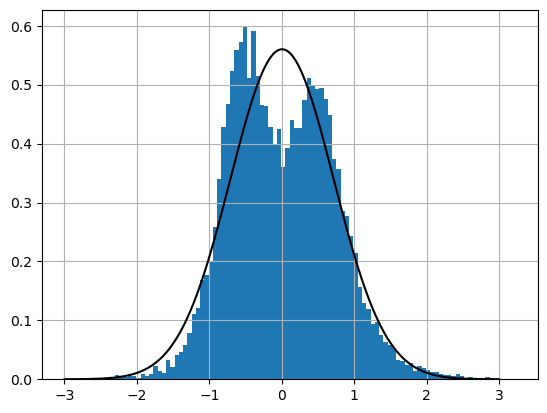

In [34]:
plt.figure()
plt.grid()
plt.hist(time,bins=100, density=True)
single_mu, single_sigma = norm.fit(time)
x = np.linspace(-3 , 3, 1000)
p = norm.pdf(x,single_mu,single_sigma)

plt.plot(x,p,'k')

0.17398021511570072


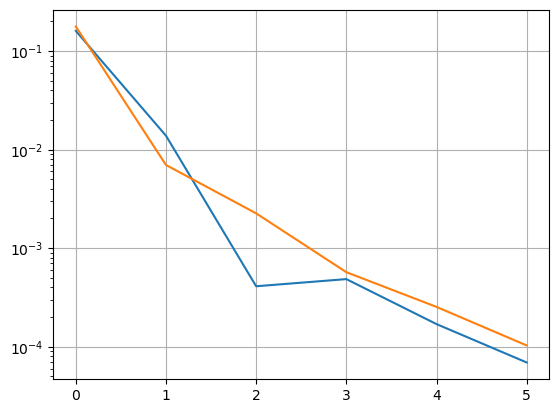

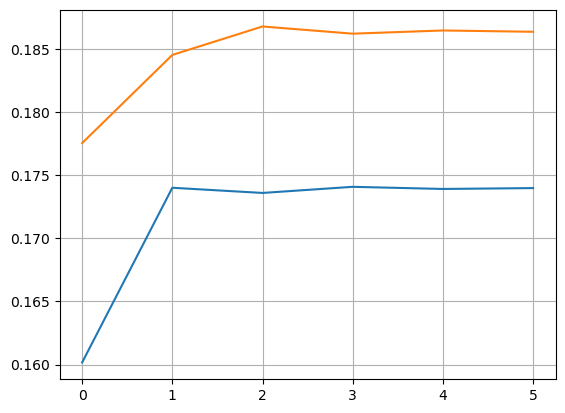

In [33]:
plt.figure()
plt.semilogy(np.abs(converg_X))
plt.semilogy(np.abs(converg_Y))
plt.grid()
plt.figure()
plt.plot(np.abs(avg_offset_x))
plt.plot(np.abs(avg_offset_y))
plt.grid()
print(np.abs(np.mean(muXF)))

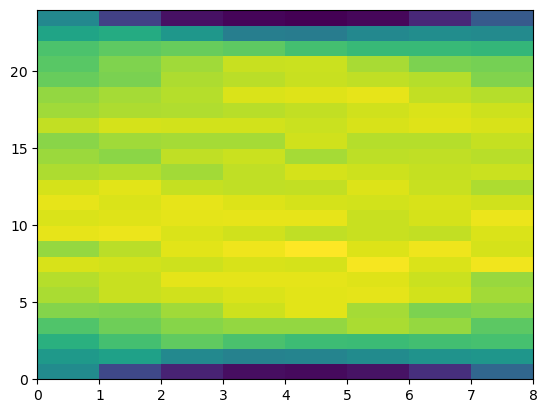

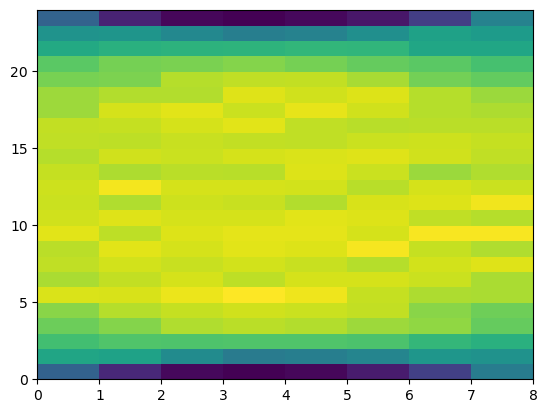

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a sample matrix
# Replace this with your own matrix
matrix = countX

# Create arrays for x and y coordinates that match the shape of the matrix
x = np.arange(matrix.shape[0])
y = np.arange(matrix.shape[1])
x, y = np.meshgrid(x, y)

# Create the 3D surface plot
plt.figure()
plt.pcolor(countX)
plt.figure()
plt.pcolor(countY)

# Set labels for the x, y, and z axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()




In [8]:
uncorrected_tracks = []
for i in range(10000) :
    event = df_hits.loc[good_candidates[i]]
    next_event = df_hits_total.loc[good_candidates[i]+1]

    hits = [Hit(event,i) for i in range(event['n_hits' ])]
    # print (hits)    
    Track = Track3D(hits)
    uncorrected_tracks.append(Track)

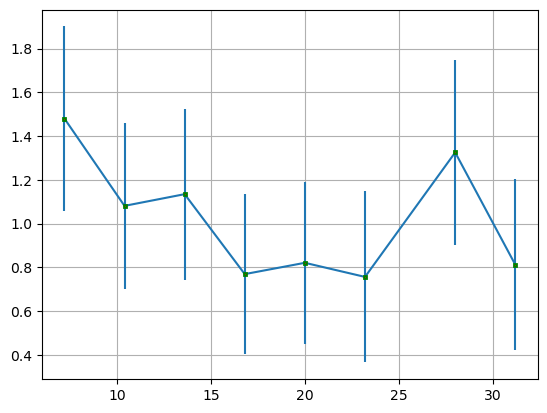

In [22]:
xtilted_tracks = [t for t in uncorrected_tracks if t.y.t>1.5]
tangeants = []
TiltedXHits = xtilted_tracks[0].x.hits

plt.Figure()
for t in xtilted_tracks:
    timestamp = []
    height = []
    error =[]
    hitsX = t.y.hits
    hitsX.sort(key = lambda hit: -hit.coord[1])
    first_stamp=hitsX[0].timestamp
    for h in hitsX:
        timestamp.append(h.timestamp-muXF[h.coord[0]-1][h.coord[1]-1])
        height.append(h.get_pos()[0])
        error.append(sigmaX[h.coord[0]-1][h.coord[1]-1])
    plt.errorbar(height,timestamp,error,marker='s', mfc='red', mec='green', ms=2, mew=2)
    plt.grid()



In [15]:
xtilted_tracks[0].show()

c:\Users\eliot\mambaforge\envs\ecal-env\Lib\site-packages\matplotlib\axes\_axes.py:6826: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\eliot\mambaforge\envs\ecal-env\Lib\site-packages\matplotlib\axes\_axes.py:6827: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

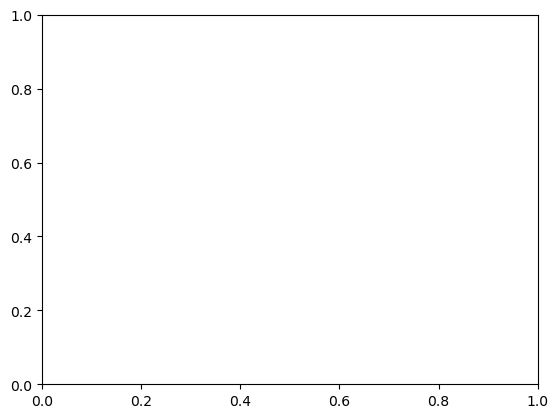

In [ ]:
# for i in range(8) :  #iteration on the 8 x-layers
#   for j in range(24) : # iteration on the 24 bars on each layers
    ## Plot the histogram and gaussian fit ***************************************************
      # Plot the histogram
    plt.hist(t_dist, bins=25, density=True, alpha=0.6, color='g')
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma[23][15] )
    plt.plot(x, p, 'k', linewidth=2)
    # title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    # plt.title(title)

    plt.show() 
          #******